<a href="https://colab.research.google.com/github/vifirsanova/spbu-mathling/blob/main/Transfer_Learning_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
Туториал Виктории Фирсановой для кафедры математической лингвистики СПбГУ

github @vifirsanova
```

# Загрузка библиотек Transformers и Datasets

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install transformers datasets

# Загрузка датасета IMDB

[Карточка датасета на HuggingFace](https://huggingface.co/datasets/imdb)

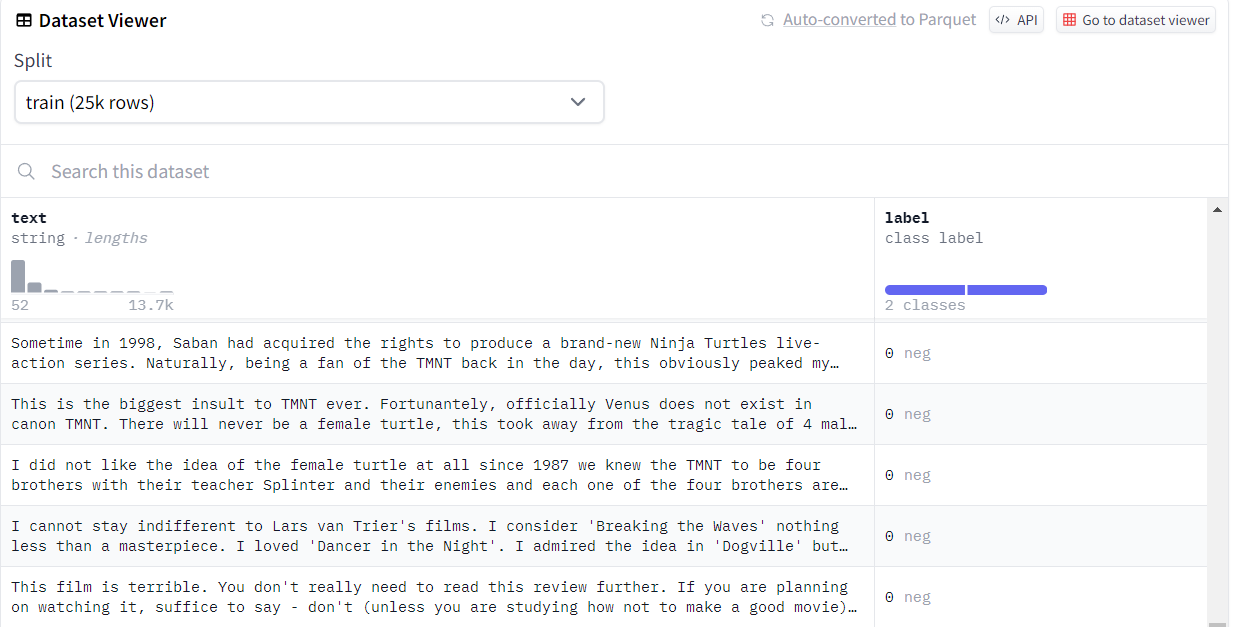

In [ ]:
from datasets import load_dataset
imdb = load_dataset("imdb")

Сохраняем в отдельные переменные тестовую и обучающую выборки.

In [ ]:
# для учебных целей перемешаем и оставим только 1000 примеров в обучающей выборке
train = imdb["train"].shuffle().select([x for x in list(range(1000))])
# оставим 100 примеров в тестовой выборке
test = imdb["test"].shuffle().select([x for x in list(range(100))])

Структура HuggingFace Datasets

In [ ]:
train

Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

Выведем на экран один положительный и один отрирательный отзыв

In [ ]:
print('Негативный отзыв\n')
[x for x in train if x['label'] == 0][0]['text']

Негативный отзыв



"Spoilers... if such a thing is possible... . . . . . . . As a rabid Robin Williams fan, I felt it necessary to buy this film as first on-screen appearance. Wow... I could not imagine a more mind-numbing movie. Essentially, the movie takes one bad joke after another that your uncle Artie would tell you after dinner and dramatizes them. Robin Williams plays a lawyer in a 30 sec skit.<br /><br />I'm all for bawdy humor, but this humor wasn't pleasantly vulgar, or ribald... it was just mind-numbing. There are no redeeming qualities to this film, other than Robin Williams fanatics, like me, who simply have to own every piece of film."

In [ ]:
print('Положительный отзыв\n')
[x for x in train if x['label'] == 1][0]['text']

Положительный отзыв



'You know how Star Trek fans flocked to all the Star Trek movies, even the really bad ones? Why? To see their heroes in action one more time. That\'s the way I feel about Doc Savage. I am a major fanatic for the character, and the prospect of seeing Doc and his crew in an adventure was overwhelming. And the first 20 minutes of the film only heightened that feeling of anticipation. Then they decided to crib elements from a number of Doc adventures and throw them into this one movie, resulting in a somewhat disjointed film. There\'s a lot of promise in here, diluted by a number of unfortunate choices (the music, the "camp" elements, etc.) But the spirit of Doc is there, and that\'s what those of us familiar with Doc and his crew respond to. So, in my long-winded way, what I\'m trying to say is that this is not a bad movie: it\'s just not as good as it should have been. And anyone who is a fan of Superman, James Bond, Indiana Jones, Buckaroo Banzai, and many other characters ought to chec

# Токенизация

Загружаем токенизатор для модели DistilBERT

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

[Обзор токенизаторов HF](https://huggingface.co/docs/transformers/tokenizer_summary)

Посмотрим, как работает этот токенизатор

- Какой это тип токенизации?
- Есть ли здесь OOV и почему?
- Как зашифрованы токены?

In [ ]:
tokenizer.tokenize(train[10]['text'])[:10]

['i', "'", 've', 'seen', 'plenty', 'of', 'sci', '-', 'fi', 'channel']

In [ ]:
tokenizer.tokenize(train[10]['text'])[-10:]

['it', "'", 's', 'dar', '##n', 'near', 'un', '##watch', '##able', '.']

Функция для быстрой токенизации текстов

In [ ]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tokenized_train = train.map(preprocess_function, batched=True)
tokenized_test = test.map(preprocess_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Структура токенизованной информации

In [ ]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1000
})

Что означают 101 и 102 в закодированных последовательностях?

In [ ]:
tokenized_train[10]['input_ids'][:11]

[101, 1045, 1005, 2310, 2464, 7564, 1997, 16596, 1011, 10882, 3149]

In [ ]:
tokenized_train[10]['input_ids'][-11:]

[2009, 1005, 1055, 18243, 2078, 2379, 4895, 18866, 3085, 1012, 102]

# Сборка модели

Подгружаем модель [DistilBERT](https://huggingface.co/distilbert-base-uncased) из хаба

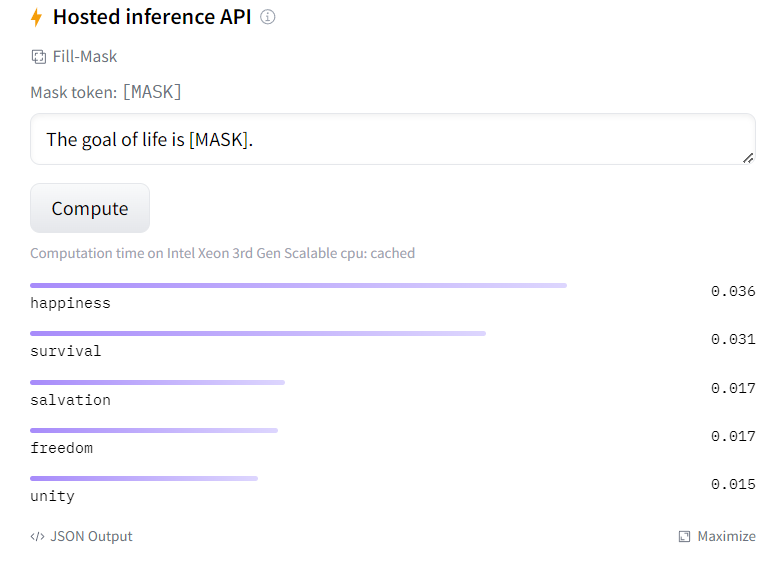



In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Функция для расчета метрик оценки производительности модели

In [ ]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

# Обучение и оценка

Trainer - инструмент от HuggingFace

С его помощью удобно задавать аргументы обучения модели, настраивать гиперпараметры

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
   output_dir="sentibert",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch"
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=126, training_loss=0.4481160905626085, metrics={'train_runtime': 111.0182, 'train_samples_per_second': 18.015, 'train_steps_per_second': 1.135, 'total_flos': 262612478229312.0, 'train_loss': 0.4481160905626085, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

<ipython-input-18-b1430cee0b64>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


{'eval_loss': 0.2759309709072113,
 'eval_accuracy': 0.89,
 'eval_f1': 0.8842105263157894,
 'eval_runtime': 3.3184,
 'eval_samples_per_second': 30.135,
 'eval_steps_per_second': 2.109,
 'epoch': 2.0}

# Сохранение и использование модели

In [ ]:
model.save_pretrained("sentibert_tuned")

Pipeline - инструмент HuggingFace, с помощью которого вам достаточно загрузить модель и подходящий токенизатор для использования модели для конкретной задачи

In [ ]:
from transformers import pipeline

sentiment_model = pipeline(task="sentiment-analysis", model="/content/sentibert_tuned", tokenizer=tokenizer)
sentiment_model(["I love this move", "This movie is horrible!"])

[{'label': 'LABEL_1', 'score': 0.810382604598999},
 {'label': 'LABEL_0', 'score': 0.8349524140357971}]